In [1]:
import random
%matplotlib inline
import networkx as nx
!pip install python-louvain

Defaulting to user installation because normal site-packages is not writeable


# Chapter 6 Tutorial

Contents:

1. Partitions
2. Modularity
3. Zachary's Karate Club
4. Louvain community detection

## 1. Partitions

A **partition** of a graph is a separation of its nodes into disjoint groups. Consider the following graph:

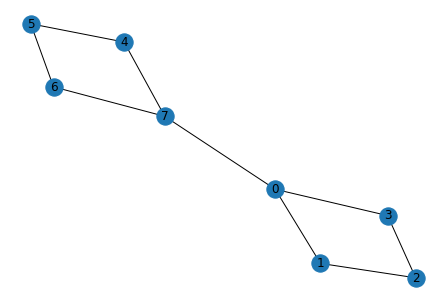

In [2]:
G = nx.Graph()

nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])

G.add_edge(0, 7)

nx.draw(G, with_labels=True)

The following is an example of a partition of these nodes:

In [3]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

Observe that every node in the graph is in exactly one of the sets in the partition. Formally, a partition is a list of sets such that every node is in exactly one set. NetworkX can verify that our partition is valid:

In [4]:
nx.community.is_partition(G, partition)

True

When developing community detection algorithms, we often make use of a *partition map*, which is a dictionary mapping node names to a partition index. This is useful for quickly comparing if two nodes are in the same cluster in the partition:

In [5]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

In this dictionary, the keys are the node names and two nodes will have the same value if they are in the same partition:

In [6]:
partition_map[0] == partition_map[7]

True

We can visualize our partition by drawing the graph with nodes colored by their partition membership:

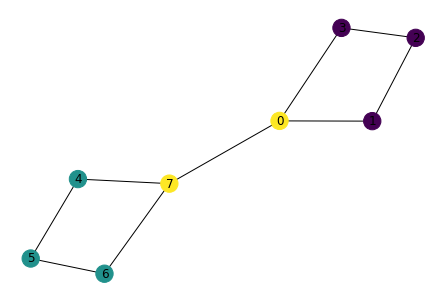

In [7]:
node_colors = [partition_map[n] for n in G.nodes]
        
nx.draw(G, node_color=node_colors, with_labels=True)

There are two trivial partitions:

1. The partition with one set containing every node;
2. The partition with N sets, each containing a single node.

A valid partition thus contains between 1 and N sets.

Feel free to experiment by changing the partition above and running the subsequent cells.

## 2. Modularity

At a high level, network community detection consists of finding a partition that achieves good separation between the groups of nodes. Before we get into how to find good partitions of a graph, we need an objective -- a way to measure how good the partition is. Modularity is one such objective function.

The modularity of a graph partition compares the number of intra-group edges with a random baseline. Higher modularity scores correspond to a higher proportion of intra-group edges, therefore fewer inter-group edges and better separation of groups.

For weighted undirected networks, as described in the text, we have
\begin{equation}
    Q_w=\frac{1}{W}\sum_C \left(W_C-\frac{s_C^2}{4W}\right),
    \label{eq:wmodul}
\end{equation}
where 
* $W$ is the total weight of the links of the network,
* $W_C$ the total weight of the internal links of cluster $C$, and
* $s_C$ the total strength of the nodes of $C$.

The total weight $W$ is half the total strength for the same reason that the number of edges $L$ is half the total degree. While this formula may look a bit complicated, it's straightforward to write code to compute the sum:

In [8]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W

In [9]:
modularity(G, partition)

0.2222222222222222

Let's compare this to a partition we would suspect to have higher modularity:

In [10]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
modularity(G, partition_2)

0.3888888888888889

### NetworkX function

NetworkX provides a modularity function that is more efficient than ours:

In [11]:
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

## 3. Zachary's Karate Club

When writing and testing community-detection algorithms, it helps to make use of benchmark networks: graphs with a known, "natural" community structure. Perhaps the most famous benchmark graph is Zachary's Karate Club. It contains 34 nodes, representing members of a karate club whose interactions were monitored over a period of three years by researchers. Links in this graph connect individuals interacting outside club activities, a proxy for social ties.

During the course of the study, a conflict between the instructor Mr. Hi (node 0) and the president, or Officer (node 33) led to a split of the club into separate groups led by Mr. Hi and Officer. In this case we know whom each member of the group followed after the split, providing empirical community labels: those members who followed Mr. Hi are said to be one community and those following the Officer make up the other.

For this graph, we assume that the post-split group composition was largely driven by the social ties: members of the same friend groups would want to be part of the same club after the split. We thus expect a good community-detection algorithm to predict the post-split group composition with high accuracy.

Zachary's karate club is such a popular benchmark graph that it has its own function in NetworkX:

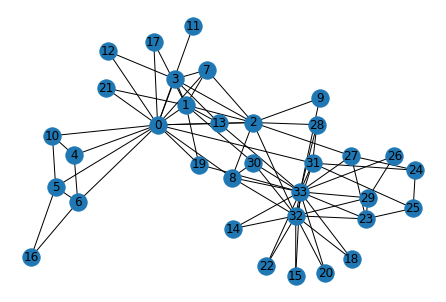

In [12]:
K = nx.karate_club_graph()
pos = nx.layout.spring_layout(K)
nx.draw(K, with_labels=True,pos =pos)

Each node in a NetworkX graph has a dictionary of *attributes* associated with it. This dictionary can hold arbitrary data about a node. We can get the attributes for a single node by giving the node name to the `nodes` object.

Each node in this graph has a `'club'` attribute, indicating whether the member followed the instructor or the president after the split:

In [13]:
K.nodes[0]

{'club': 'Mr. Hi'}

In [14]:
#typo
#K.node[9]
K.nodes[9]

{'club': 'Officer'}

We can visualize these labels by coloring each node according to its `'club'` attribute:

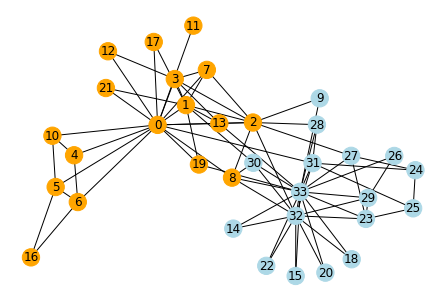

In [15]:
K = nx.karate_club_graph()
club_color = {
    'Mr. Hi': 'orange',
    'Officer': 'lightblue',
}
# typo 
#node_colors = [club_color[K.node[n]['club']] for n in K.nodes]
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]
nx.draw(K, node_color=node_colors, with_labels=True, pos = pos)

This separation looks good, in that there are relatively few inter-community links as opposed to intra-community links. Let's create a graph partition based on these labels and measure its modularity.

We can do this by creating a dictionary of two sets, one for each value of the nodes' `'club'` attribute, then assigning the nodes to the corresponding set. 

In [16]:
groups = {
    'Mr. Hi': set(),
    'Officer': set(),
}

for n in K.nodes:
    #typo
    # club = K.node[n]['club']
    club = K.nodes[n]['club']
    groups[club].add(n)
    
groups

{'Mr. Hi': {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 'Officer': {9,
  14,
  15,
  18,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}}

By using the dictionary's `.values()` method, we can get a list of sets that define our partition:

In [17]:
empirical_partition = list(groups.values())
empirical_partition

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

In [18]:
nx.community.is_partition(K, empirical_partition)

True

Since our partition is indeed a valid partition, we can get the modularity of this partition:

In [19]:
nx.community.quality.modularity(K, empirical_partition)

0.3582347140039448

This is a relatively high modularity, which is what we expect.

### Comparison to a random partition

For the sake of comparison, let's generate a random partition of this network and check its modularity. We would expect a modularity close to zero in this case.

First we generate a sample of 17 nodes, half the total number of nodes, and assign them to one community. Our second community then includes the nodes in the graph not in the first community. We can use some set arithmetic to do this concisely:

In [20]:
random_nodes = random.sample(K.nodes, 17)
random_partition = [set(random_nodes),
                    set(K.nodes) - set(random_nodes)]
random_partition

[{0, 1, 3, 4, 7, 9, 10, 11, 12, 13, 14, 15, 22, 24, 26, 27, 30},
 {2, 5, 6, 8, 16, 17, 18, 19, 20, 21, 23, 25, 28, 29, 31, 32, 33}]

We can visualize this partition and observe that the communities are much less natural-looking, as we would expect from a random assignment.

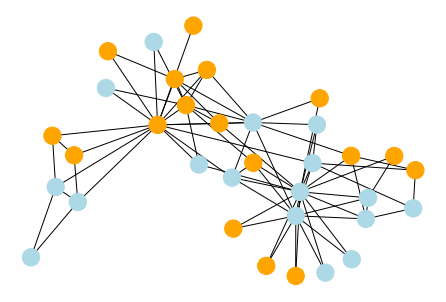

In [21]:
random_node_colors = ['orange' if n in random_nodes else 'lightblue' for n in K.nodes]
nx.draw(K, node_color=random_node_colors, pos = pos)

And finally we can test the modularity of this partition:

In [22]:
nx.community.quality.modularity(K, random_partition)

0.03320184089414857

Since this is a random process the modularity won't be exactly zero, but it should be fairly close. Go ahead and repeat the process of generating a random partition and testing its modularity -- it will fluctuate around its mean value of zero.

# 4. Louvain community detection

Our task in this part will be to use Louvain algorithm. Since NetworkX does not have a corresponding built-in method, we will need to install from other source. https://github.com/taynaud/python-louvain

First, let's install by using `pip install python-louvain`,
then, we can `import community as community_louvain` and use `community_louvain.best_partition(G)` to get partition. 

In the rest of the section, we'll use the Karate Club graph here because we know the ground-truth community labels and can compare the result obtained from the algorithm.

## 4.1 Create a partition sequence


In [23]:
import community as community_louvain

We can get the partition by using the following function.

In [24]:
partition_map = community_louvain.best_partition(K)

As you can see the output is a dictionary.

In [25]:
partition_map

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 1,
 5: 1,
 6: 1,
 7: 0,
 8: 2,
 9: 2,
 10: 1,
 11: 0,
 12: 0,
 13: 0,
 14: 2,
 15: 2,
 16: 1,
 17: 0,
 18: 2,
 19: 0,
 20: 2,
 21: 0,
 22: 2,
 23: 2,
 24: 3,
 25: 3,
 26: 2,
 27: 2,
 28: 3,
 29: 2,
 30: 2,
 31: 3,
 32: 2,
 33: 2}

## 4.2 Evaluate the modularity of the partition

We now have a partition and a function to calculate the modularity of a partition. It's time to check the modularity value of the Louvain result.  
First, we need to convert the partition_map into the partition format.

In [26]:
partition= {}
for node, p in partition_map.items():
    if p not in partition:
        partition[p] = [node]
    else:
        partition[p].append(node)

In [27]:
partition

{0: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 1: [4, 5, 6, 10, 16],
 2: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33],
 3: [24, 25, 28, 31]}

In [28]:
partition = list(partition.values())

In [29]:
partition

[[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [4, 5, 6, 10, 16],
 [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33],
 [24, 25, 28, 31]]

Interesting! The Louvain partition of the karate club graph has four components! Let's check its modularity value. 

In [30]:
nx.community.quality.modularity(K, partition)

0.4151051939513477

It's higher than the "ground truth" communities we evaluated in section 3, which is a good sign, but for the specific problem of trying to predict the post-split community membership, a clustering into four groups is useless to us. Nevertheless, let's try visualize it and compare it with the groud truth. 
## 4.3 Visualization

We could use `plt.subplot()` to include muliple subplots in one figure.

Text(0.5, 1.0, 'Actual communities')

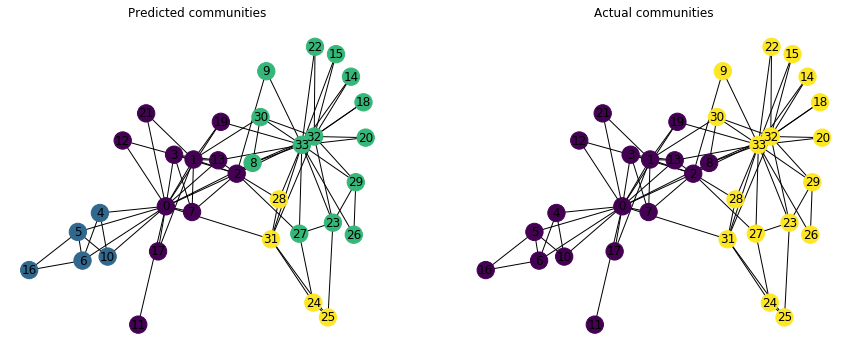

In [31]:
import matplotlib.pyplot as plt

pos = nx.layout.spring_layout(K)
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
node_colors = [partition_map[n] for n in K.nodes()]
nx.draw(K, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Predicted communities')

plt.subplot(1, 2, 2)
node_colors = [K.nodes[n]['club'] == 'Officer' for n in K.nodes()]
nx.draw(K, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Actual communities')


Networkx has built-in functions for both asynchronous and synchronous Label Propagation methods.  
we need to  `from networkx.algorithms import community`  
**asynchronous**: `community.asyn_lpa_communities(G)`  
**synchronous** : `community.label_propagation_communities(G)`  
## Exercise 1: Label propagation
Please run both versions of Label Propagation on karate graph 10 times, pick the partition with the largest modularity in both cases and visualize them.

It should be noted that the return of NetworkX community functions are partition, or partition_map.

Therefore, in Ex1, you would also need to write a function to change partiton to partiton_map if you want to adopt the code for visualization.

In [32]:
from networkx.algorithms import community
# asynchronous

# generate 10 different networks
alpa_modularity_list = []
for i in range(10):
    alpa_partition = list(community.asyn_lpa_communities(K))
    # get the modularity value
    alpa_modularity = nx.community.quality.modularity(K, alpa_partition)
    alpa_modularity_pair = (alpa_modularity, alpa_partition)
    alpa_modularity_list.append(alpa_modularity_pair)

max_alpa_modularity = max(alpa_modularity_list, key = lambda x: x[0])
max_alpa_modularity_value = max_alpa_modularity[0]
max_alpa_modularity_partition = max_alpa_modularity[1]
print("The largest modularity in Asynchronous Label Propagation method is", max_alpa_modularity_value)

# synchronous

# generate 10 different networks
propagation_modularity_list = []
for i in range(10):
    propagation_partition = list(community.label_propagation_communities(K))
    # get the modularity value
    propagation_modularity = nx.community.quality.modularity(K, propagation_partition)
    propagation_modularity_pair = (propagation_modularity, propagation_partition)
    propagation_modularity_list.append(propagation_modularity_pair)

max_propagation_modularity = max(propagation_modularity_list, key = lambda x: x[0])
max_propagation_modularity_value = max_propagation_modularity[0]
max_propagation_modularity_partition = max_propagation_modularity[1]
print("The largest modularity in Aynchronous Label Propagation method is", max_propagation_modularity_value)

The largest modularity in Asynchronous Label Propagation method is 0.41559829059829057
The largest modularity in Aynchronous Label Propagation method is 0.3251150558842867


In [33]:
# create a partition map function
def partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

alpa_partition_map = partition_map(max_alpa_modularity_partition)
propagation_partition_map = partition_map(max_propagation_modularity_partition)

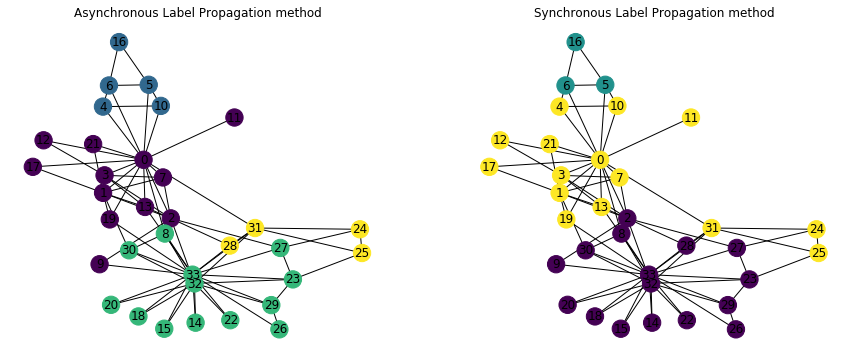

In [34]:
import matplotlib.pyplot as plt

pos = nx.layout.spring_layout(K)
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
node_colors = [alpa_partition_map[n] for n in K.nodes()]
nx.draw(K, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Asynchronous Label Propagation method')

plt.subplot(1, 2, 2)
node_colors = [propagation_partition_map[n] for n in K.nodes()]
nx.draw(K, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Synchronous Label Propagation method');